In [1]:
# importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from qiskit import QuantumCircuit, transpile, Aer, assemble
from qiskit.circuit import ParameterVector
import random

In [2]:
# reading the data
data = pd.read_csv('Iris.csv')
data.set_index('Id', inplace=True)
data.sample(5)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
Id,,,,,
39,4.4,3.0,1.3,0.2,Iris-setosa
69,6.2,2.2,4.5,1.5,Iris-versicolor
8,5.0,3.4,1.5,0.2,Iris-setosa
145,6.7,3.3,5.7,2.5,Iris-virginica
58,4.9,2.4,3.3,1.0,Iris-versicolor


In [3]:
# search for null values
data.isnull().sum()

SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

In [4]:
# types of flowers
types = data['Species'].unique()
types

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [5]:
# replacing the types with numerical data
data.replace(types[0],+1,inplace=True)
data.replace(types[1],0,inplace=True)
data.replace(types[2],-1,inplace=True)
data.sample(5)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
Id,,,,,
82,5.5,2.4,3.7,1.0,0
50,5.0,3.3,1.4,0.2,1
70,5.6,2.5,3.9,1.1,0
100,5.7,2.8,4.1,1.3,0
118,7.7,3.8,6.7,2.2,-1


<AxesSubplot:>

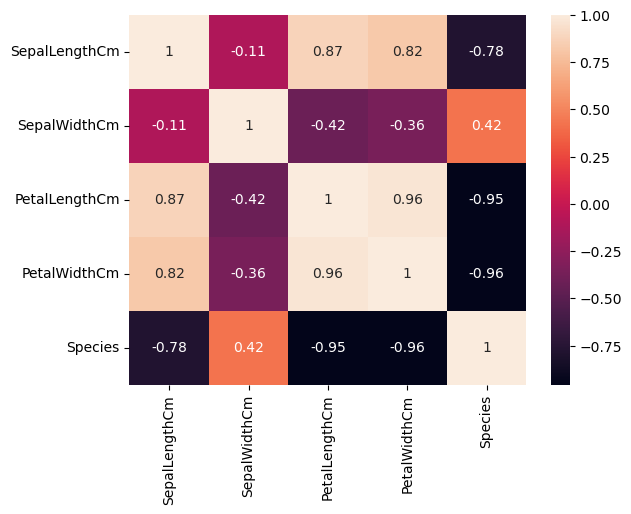

In [6]:
# correlation matrix
sns.heatmap(data.corr(), annot=True)

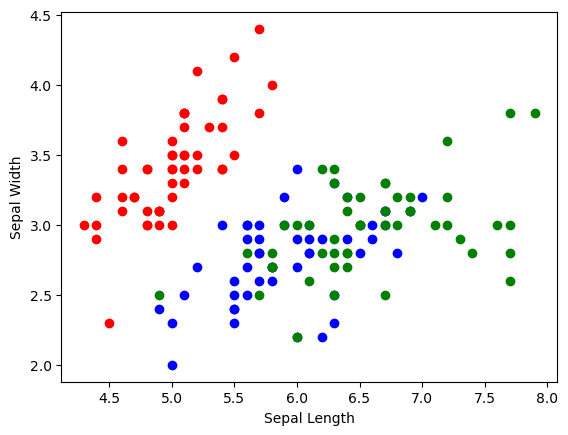

In [7]:
# Scatter Plot
plt.scatter(data['SepalLengthCm'][:50],data['SepalWidthCm'][:50], color='red')
plt.scatter(data['SepalLengthCm'][50:100],data['SepalWidthCm'][50:100], color='blue')
plt.scatter(data['SepalLengthCm'][100:],data['SepalWidthCm'][100:], color='green')
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.show()

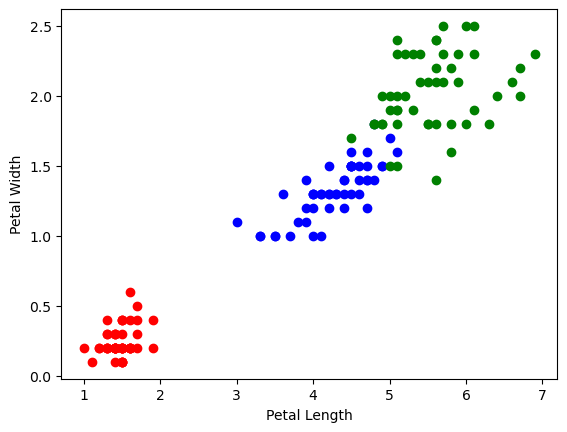

In [8]:
# Scatter Plot
plt.scatter(data['PetalLengthCm'][:50],data['PetalWidthCm'][:50], color='red')
plt.scatter(data['PetalLengthCm'][50:100],data['PetalWidthCm'][50:100], color='blue')
plt.scatter(data['PetalLengthCm'][100:],data['PetalWidthCm'][100:], color='green')
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.show()

In [9]:
# Splitting the data
from sklearn.model_selection import train_test_split
x = data.iloc[:,:4].to_numpy()
y = data.iloc[:,4].to_numpy()
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size = 0.3, random_state=25)

In [10]:
# Dimensionality Reduction using PCA
from sklearn.decomposition import PCA
pca = PCA(.95)
pca.fit(xtrain)
xtrain = pca.transform(xtrain)
xtest = pca.transform(xtest)

qubits = len(xtrain[0])

In [11]:
# Scaling the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(xtrain)
xtrain = scaler.transform(xtrain)
xtest = scaler.transform(xtest)

In [12]:
# FeatureMap Circuit
def FeatureMap(n,reps):
    qc = QuantumCircuit(n)
    params = ParameterVector('x',n)
    for i in range(reps):
        for j in range(n):
            qc.h(j)
            qc.rz(params[j],j)
            qc.ry(params[j],j)
            if j!=0:
                qc.rzz(params[j],0,j)
    return qc

In [13]:
# get the kernel matrix
def kernel(x,y,Fmap):
    
    def statevector(circuit):
        backend = Aer.get_backend('statevector_simulator')
        qobj = assemble(circuit)
        result = backend.run(qobj).result()
        sv = result.get_statevector(circuit)
        return np.array(sv)

    def element(i,j):
        qc = Fmap
        qc1 = qc.bind_parameters(i)
        qc2 = qc.bind_parameters(j)
        sv1 = np.matrix(statevector(qc1))
        sv2 = np.matrix(statevector(qc2))
        return abs(np.matmul(sv1,sv2.T.conj()))**2
    
    nx = len(x)
    ny = len(y)
    matrix = np.zeros((nx,ny))
    for i in range(nx):
        for j in range(ny):
            ele = element(x[i],y[j])
            matrix[i][j] = ele
    return matrix

In [14]:
# inputing the data
Fmap = FeatureMap(qubits,1)
trainmat = kernel(xtrain,xtrain,Fmap)
testmat = kernel(xtest,xtrain,Fmap)

In [15]:
# implementing a classifier using the computed kernel
from sklearn.svm import SVC
svc = SVC(kernel='precomputed')
svc.fit(trainmat, ytrain)
score = svc.score(testmat, ytest)
ypred = svc.predict(testmat)
print(f'Precomputed kernel classification test score: {score}')

Precomputed kernel classification test score: 0.9555555555555556


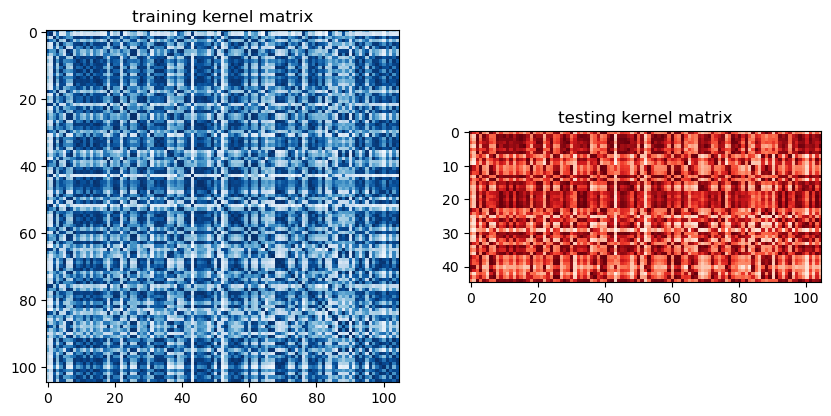

In [16]:
# plotting the kernel matrix
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(trainmat),interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("training kernel matrix")
axs[1].imshow(np.asmatrix(testmat), interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("testing kernel matrix")
plt.show()